In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import silhouette_score

# load cleaned data
df = pd.read_csv("data/HR_data_cleaned.csv")

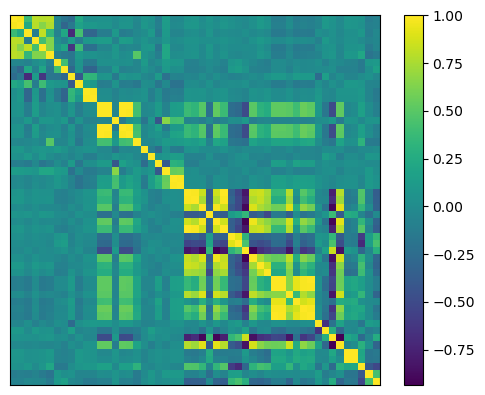

In [2]:
# feature selection by correlation between columns

def select_cols_to_drop(df, corr_cutoff):
    # continuous columns
    continuous_cols = df.columns[0:51]

    # absolute value of correlation matrix
    corr_matrix = df[continuous_cols].corr().abs()

    # upper triangular array of True booleans
    bool_array = np.ones(corr_matrix.shape).astype(bool)
    T = np.triu(bool_array, 1)

    T_corr_matrix = corr_matrix.where(T)

    # array of columns to drop
    drop_cols = []

    # drop columns that have at least corr_cutoff absolute correlation with at least one other column
    for col in T_corr_matrix.columns:
        if any(T_corr_matrix[col] > corr_cutoff):
            drop_cols.append(col)
    
    return drop_cols

# plot absolute value correlation matrix (without taking absolute value first)
continuous_cols = df.columns[0:51]
plt.imshow(df[continuous_cols].corr())
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [3]:
# select features to use for clustering

drop_cols = select_cols_to_drop(df, corr_cutoff=0.8)
print(f"Number of columns to drop: {len(drop_cols)}")

cluster_cols = df[continuous_cols].drop(columns=drop_cols).columns
print(f"Number of columns to use for clustering: {len(cluster_cols)}")
print(f"Columns: {cluster_cols}")

cluster_df =df[cluster_cols]

Number of columns to drop: 25
Number of columns to use for clustering: 26
Columns: Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean',
       'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis',
       'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max',
       'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_T_Mean', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT',
       'EDA_TD_P_ReT'],
      dtype='object')


# Model selection

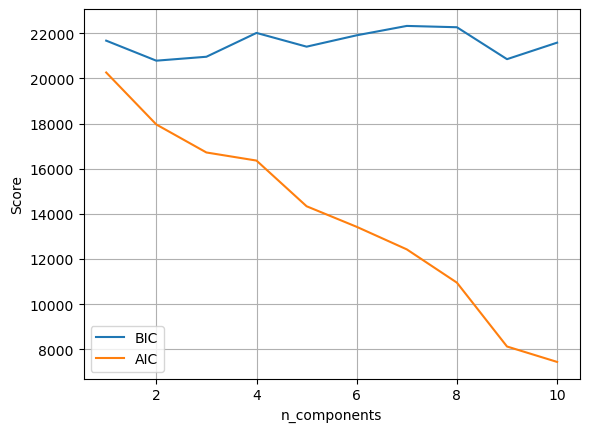

In [4]:
n_components = np.arange(1, 11) #n components to try
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster_df)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster_df) for m in models], label='BIC')
plt.plot(n_components, [m.aic(cluster_df) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.grid(True)
plt.show()

around 9 components should be optimal

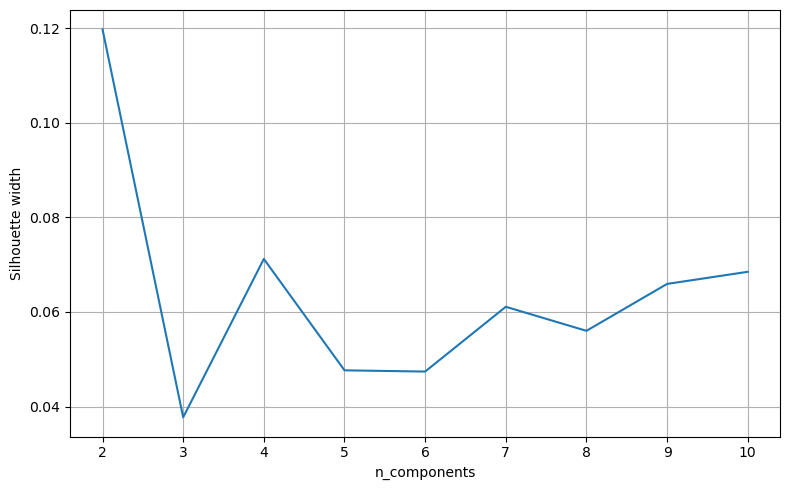

In [5]:
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    labels = gmm.fit_predict(cluster_df)
    score = silhouette_score(cluster_df, labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores)
plt.xlabel('n_components')
plt.ylabel('Silhouette width')
plt.grid(True)
plt.tight_layout()
plt.show()

either 2 or 4 components should be optimal

# GMM

In [11]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm_labels = gmm.fit_predict(cluster_df)
df['gmm_cluster'] = gmm_labels

# Visualize

In [12]:
summary = df.groupby('gmm_cluster')[[
    'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
    'nervous', 'attentive', 'afraid', 'active', 'determined'
]].mean().round(2)

display(summary)


,Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
gmm_cluster,,,,,,,,,,,
0,2.02,1.41,1.09,1.95,1.23,1.80,1.30,2.52,1.00,2.14,2.48
1,2.17,1.36,1.07,2.29,1.28,2.22,1.47,2.92,1.05,2.75,3.02
2,1.77,1.27,1.03,2.00,1.16,2.00,1.27,2.52,1.11,2.20,2.62
3,1.93,1.36,1.03,2.33,1.14,2.59,1.36,2.95,1.03,2.74,3.29


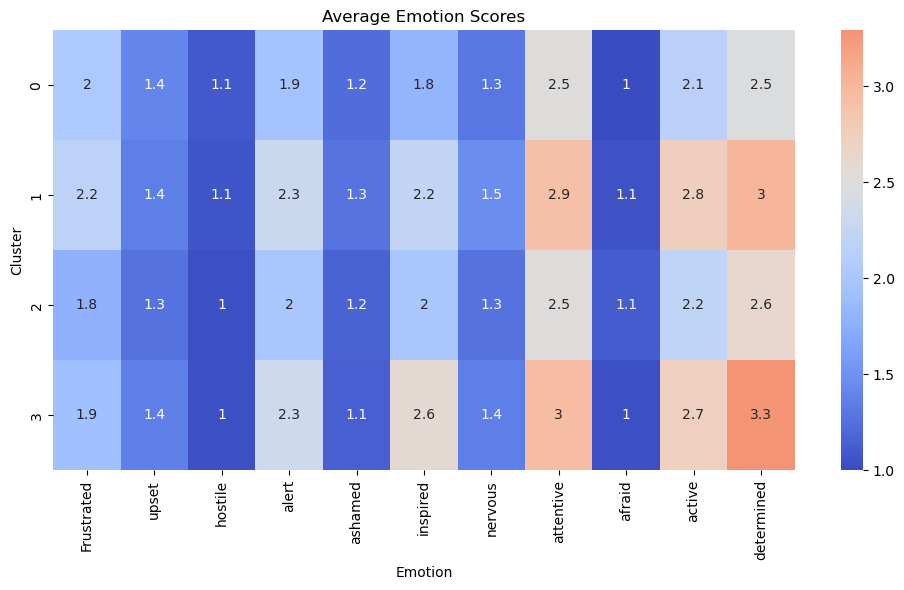

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(summary, annot=True, cmap="coolwarm", center=2.5)
plt.title("Average Emotion Scores")
plt.xlabel("Emotion")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


Cluster 1 and 3 seems more active, attentive and determined, while cluster 0 and 2 seems more relaxed.

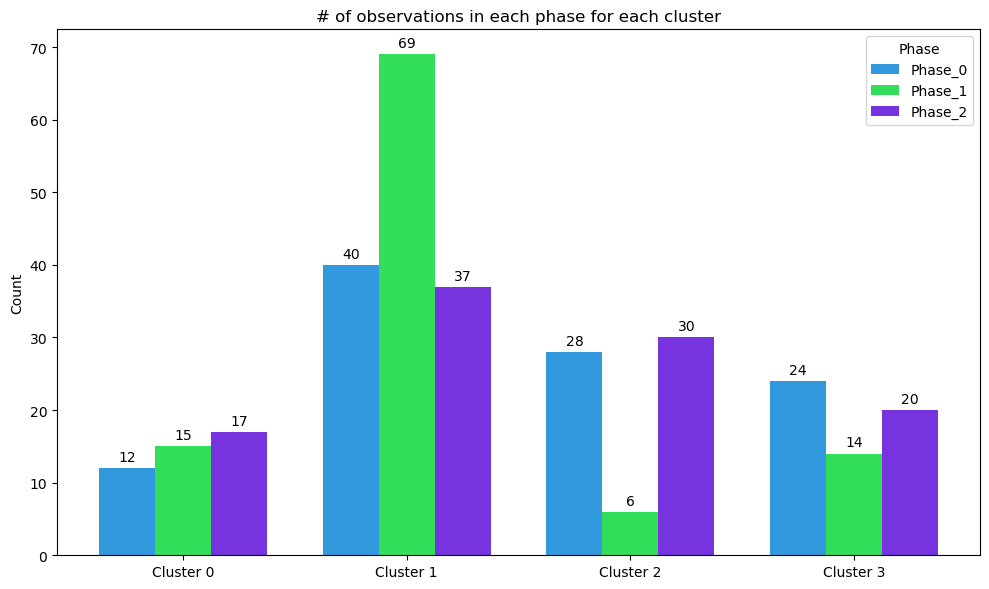

In [14]:
num_clusters = len(np.unique(gmm_labels))
phases = ["Phase_0", "Phase_1", "Phase_2"]
colors = ["#3399de", "#33de5a", "#7633de"]

counts = []
for phase in phases:
    phase_mask = df[phase] == True
    cluster_counts = df[phase_mask]['gmm_cluster'].value_counts().sort_index()
    
    complete_counts = [cluster_counts.get(i, 0) for i in range(num_clusters)]
    counts.append(complete_counts)

tick_space = np.arange(num_clusters)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, phase_count in enumerate(counts):
    offset = width * i
    rects = ax.bar(tick_space + offset, phase_count, width, label=phases[i], color=colors[i])
    ax.bar_label(rects, padding=3)

ax.set_xticks(tick_space + width, [f"Cluster {i}" for i in range(num_clusters)])
ax.set_ylabel("Count")
ax.set_title("# of observations in each phase for each cluster")
ax.legend(title="Phase")
plt.tight_layout()
plt.show()


Cluster 1 seems to have most participants in phase 1 (puzzle solving), while cluster 2 has most participant in pre-task/post-task stage

In [251]:
# emotion_cols = [
#     'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired',
#     'nervous', 'attentive', 'afraid', 'active', 'determined'
# ]

# for emotion in emotion_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(data=df, x='gmm_cluster', y=emotion)
#     plt.title(f'{emotion.capitalize()}')
#     plt.xlabel('Cluster')
#     plt.ylabel(f'Score')
#     plt.tight_layout()
#     plt.show()
